# A Vector RAG Application (with Optional Re-ranker) for asking Quantunm Mechanics related FAQs - Diagram
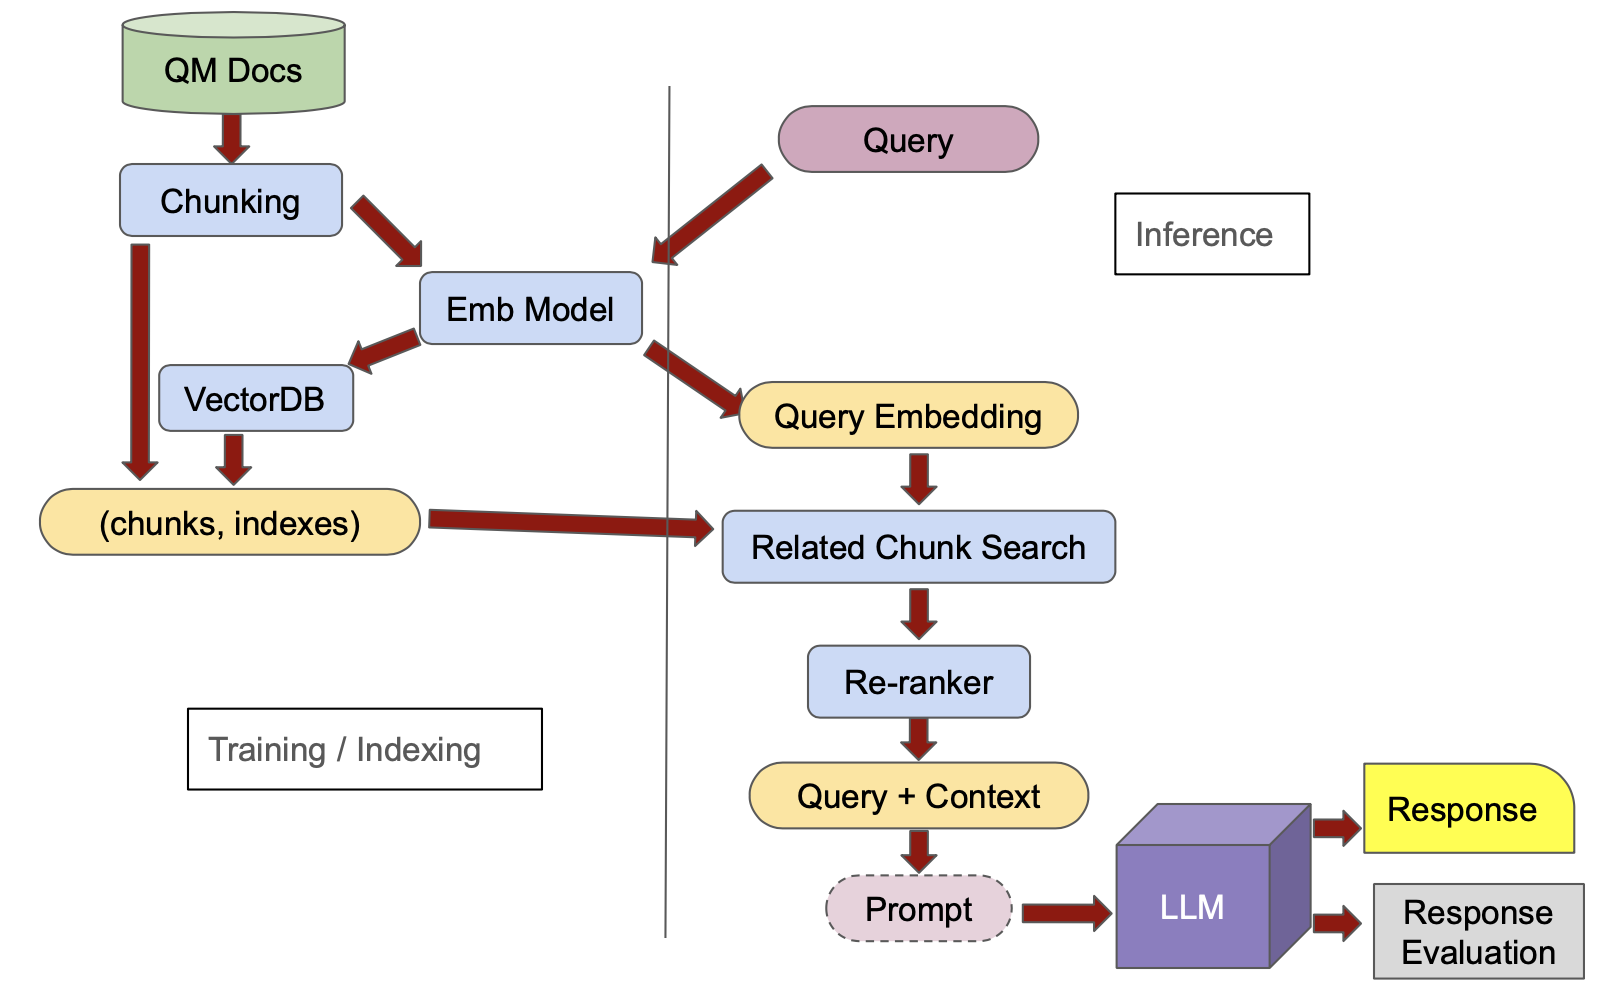

# Vector RAG Application (with Optional Re-ranker) for asking Quantunm Mechanics related FAQs - Actual Steps Followed
- Install & Import Dependency Packages
- CONFIG_DICT (to be used for configuring various experiments, A/B tesing)
- Chunker classes (Linear => Semantic, Semantic chunker uses embedding similarity to refine the chunks)
- VectorDB class for ChromaDB
- LLM_Model class (mainly for Response Generation and Evaluation)
- RAGMain class (deals with generating query response)
- RAGEval class (integrates both query response and evaluation)
- Main Flow - Vector RAG for QM FAQ
  - Training/Indexing Flow
      - Load QM docs => Extract (text, tables, images) => Perform (Linear+Semantic) Chunking => Indexing of Chunks => Store Indexes to VectorDB.
  - Inference Flow
      - Load Chunks => Query Embedding => Get related Chunks => Re-rank related Chunks (optional) => Create Prompt with (Query, Related Chunks) => Get Query Response from LLM.

#### Install & Import Dependency Packages

In [ ]:
# !pip install PyMuPDF openai google-generativeai numpy -q
!pip install -q pymupdf chromadb openai google-generativeai transformers sentence_transformers
!pip install faiss-cpu
# !pip install faiss-gpu
!pip install pdfplumber
# !pip install -U FlagEmbedding
# !pip install vllm

In [ ]:
import time
import os
import glob
import re
import json
import numpy as np
import pickle
import torch
import fitz  # PyMuPDF
import chromadb
import google.generativeai as genai
from sentence_transformers import SentenceTransformer
from sentence_transformers import CrossEncoder
from transformers import AutoTokenizer, AutoModelForCausalLM
# from accelerate import init_empty_weights
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import openai
from openai import OpenAI
from google.colab import userdata, drive
import textwrap

# from vllm import LLM, SamplingParams

#### Access the Drive for QM docs

In [ ]:
# --- Mount Google Drive ---
# This allows the script to access your PDF file from Google Drive.
drive.mount('/content/drive')
print("Google Drive mounted successfully.")
time.sleep(10)

#### CONFIG_DICT

In [ ]:
from google.colab import userdata

INFER_ONLY_MODE = False
# Each Expt_id points to a specific configuration for the RAG Expt: CONFIG_DICT_BY_EXPT[EXPT_ID]
EXPT_ID = "v_1" # [v_1: without Re-ranker, v_2: with Jina Re-ranker]
DATA_PATH = userdata.get('QM_DATA_PATH') # "Path where the QM training docs are stored"
RESULT_PATH = userdata.get("QM_RESULT_PATH") # "Path where the QM RAG Expt Results are stored"
EMB_FOLDER_NAME = "QM_{}_{}" # e.g., "QM_chroma_emb_model" or "QM_faiss_emb_model"
CHUNK_FILENAME = "QM_chunks.json"
QUERY_RESPONSE_EVAL_FILENAME = "query_response_eval.pkl"

# print(DATA_PATH)
# print(RESULT_PATH)

RESP_PROMPT = ""

In [ ]:
CONFIG_DICT_BY_EXPT = {}

CONFIG_DICT_BY_EXPT["v_1"] = {
    "chunking_strategy": "linear_semantic",
    "vector_db": "faiss",
    "embedding_model": "sentence-transformers/all-MiniLM-L6-v2",
    "reranker_model": None,
    "responese_model": "gpt-3.5-turbo",
    "response_temp": 0.5,
    "response_top_p": 0.5,
    "k_related_chunks": 2,
    "top_k_reranked_chunks": 0,
}

CONFIG_DICT_BY_EXPT["v_2"] = {
    "chunking_strategy": "linear_semantic",
    "vector_db": "faiss",
    "embedding_model": "BAAI/bge-small-en-v1.5",
    "reranker_model": "jinaai/jina-reranker-v2-base-multilingual",
    "responese_model": "gpt-3.5-turbo",
    "response_temp": 0.2,
    "response_top_p": 0.1, # default for OpenAI
    "k_related_chunks": 10,
    "top_k_reranked_chunks": 1,
}

config_dict = CONFIG_DICT_BY_EXPT[EXPT_ID]

In [ ]:
EMB_MODEL_NAME = config_dict["embedding_model"]
RERANKER_MODEL_NAME = config_dict["reranker_model"]
RESP_MODEL_NAME = config_dict["responese_model"]
RESP_TEMP = config_dict["response_temp"]
RESP_TOP_P = config_dict["response_top_p"]
K_RELATED_CHUNKS = config_dict["k_related_chunks"]
TOP_K_RERANKED_CHUNKS = config_dict["top_k_reranked_chunks"]

QM_RAG_EXPT_OUTPUT_FOLDER = os.path.join(RESULT_PATH, EXPT_ID) # config_dict["chunk_emb_saving_folder_path"]
# CHUNK_FILENAME = config_dict["chunk_filename"]
if EMB_MODEL_NAME.__contains__("/"):
  EMB_FOLDER = EMB_FOLDER_NAME.format(config_dict["vector_db"], EMB_MODEL_NAME.split("/")[1])
else:
  EMB_FOLDER = EMB_FOLDER_NAME.format(config_dict["vector_db"], EMB_MODEL_NAME)
# print(EMB_FOLDER)
CHUNKS_FILE_PATH = os.path.join(QM_RAG_EXPT_OUTPUT_FOLDER, CHUNK_FILENAME)
VECTOR_DB_PATH = os.path.join(QM_RAG_EXPT_OUTPUT_FOLDER, EMB_FOLDER)
RESULT_FOLDER_BY_TEMP = os.path.join(QM_RAG_EXPT_OUTPUT_FOLDER, "temp_"+str(RESP_TEMP))
QUERY_RESPONSE_EVAL_PATH = os.path.join(RESULT_FOLDER_BY_TEMP, QUERY_RESPONSE_EVAL_FILENAME)

if not os.path.isdir(QM_RAG_EXPT_OUTPUT_FOLDER):
  os.mkdir(QM_RAG_EXPT_OUTPUT_FOLDER)
if not os.path.isdir(VECTOR_DB_PATH):
  os.mkdir(VECTOR_DB_PATH)
if not os.path.isdir(RESULT_FOLDER_BY_TEMP):
  os.mkdir(RESULT_FOLDER_BY_TEMP)

# print(f"CHUNKS_FILE_PATH: {CHUNKS_FILE_PATH}")
# print(f"VECTOR_DB_PATH: {VECTOR_DB_PATH}")
# print(f"RESULT_FOLDER_BY_TEMP: {RESULT_FOLDER_BY_TEMP}")

In [ ]:
data_folder_path = DATA_PATH
qm_pdf_path = os.path.join(data_folder_path, "*.pdf")
qm_pdf_path_arr = glob.glob(qm_pdf_path)
# print(qm_pdf_path_arr)

#### API Keys

In [ ]:
# --- Google, OpenAI, HuggingFace API_Keys Setup ---
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
genai.configure(api_key=GEMINI_API_KEY)
print("Google API Key configured successfully.")
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY_1')
print("OpenAI API Key loaded successfully.")
OPENAI_ORG_ID = userdata.get('OPENAI_ORG_ID')
print("OpenAI Org ID Key loaded successfully.")
HF_API_KEY = userdata.get('HF_API_KEY')
print("HF API KEY Key loaded successfully.")

os.environ['HF_TOKEN'] = HF_API_KEY

#### PDF Extractor class

In [ ]:
class PDFExtractor(object):
    def __init__(self, pdf_paths):
        """PDF Extractor object extracts text, images and tables from a list of pdf paths"""
        self.pdf_paths = pdf_paths

    def extract_text(self):
        """Extract Text"""
        import pdfplumber
        pdf_paths = self.pdf_paths
        full_text = ""
        for pdf_path in pdf_paths:
            # print(f"Extracting text from {pdf_path}")
            print(f"Extracting text from Training Corpus Documents")
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    text = page.extract_text()
                    if text:
                        full_text += text + "\n"
        return full_text

    def extract_tables(self):
        """Extract Tables"""
        import pdfplumber
        pdf_paths = self.pdf_paths
        tables = []
        for pdf_path in pdf_paths:
            print(f"Extracting tables from {pdf_path}")
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    page_tables = page.extract_tables()
                    for table in page_tables:
                        tables.append(table)
        return tables

    def extract_images(self, output_dir='images'):
        """Extract Images and dumps to the output directory"""
        from PIL import Image
        import fitz  # PyMuPDF
        import os
        pdf_paths = self.pdf_paths
        images = []
        os.makedirs(output_dir, exist_ok=True)
        for pdf_path in pdf_paths:
            print(f"Extracting from {pdf_path}")
            doc = fitz.open(pdf_path)
            for i in range(len(doc)):
                for img_index, img in enumerate(doc.get_page_images(i)):
                    xref = img[0]
                    pix = fitz.Pixmap(doc, xref)
                    if pix.n < 5:  # this is GRAY or RGB
                        img_path = f"{output_dir}/page_{i+1}_img_{img_index}.png"
                        pix.save(img_path)
                        images.append(Image.open(img_path))
                    pix = None
        print(f"{len(images)} images exported from {len(doc)} documents")
        return images

#### Chunker classes (Linear, Semantic)

In [ ]:
class LinearChunker(object):
    def __init__(self):
        """Create a Linear Chunker using RecursiveCharacterTextSplitter from Langchain"""
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        self.chunker = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=100
        )
    def get_chunks(self,full_text):
        """
        Get Chunks from the Chunker. This implementation will depend on the chosen Linear Chunker.
        """
        chunks = self.chunker.split_text(full_text)
        return chunks

In [ ]:
# Semantic Chunking
class SemanticChunker(object):
    def __init__(self, model_name='sentence-transformers/all-MiniLM-L6-v2'):
        """Create a Semantic Chunker using an LLM (LLM gives sentence embeddings),
        Deciding chunk boundaries based on sentence embedding similarity scores"""
        self.model_name = model_name
        if self.model_name in ["sentence-transformers/all-mpnet-base-v2", "sentence-transformers/all-MiniLM-L6-v2", \
                               "BAAI/bge-small-en-v1.5", "BAAI/bge-large-en-v1.5"]:
            from sentence_transformers import SentenceTransformer
            # from accelerate import init_empty_weights
            # from transformers import AutoModelForSequenceClassification, AutoTokenizer
            self.model = SentenceTransformer(model_name)
        elif self.model_name in ["models/embedding-001"]:
            pass
        elif self.model_name in ["text-embedding-3-small"]:
            self.model = OpenAI(api_key=OPENAI_API_KEY)

    def get_embeddings(self, linear_chunks, normalize_embeddings = True):
        """Get Sentence Embeddings, normalize_embeddings for easier calculation of sent embeddings' similarity score"""
        embeddings = None
        if self.model_name in ["sentence-transformers/all-mpnet-base-v2", "sentence-transformers/all-MiniLM-L6-v2", \
                               "BAAI/bge-small-en-v1.5", "BAAI/bge-large-en-v1.5"]:
            embeddings = self.model.encode(linear_chunks, convert_to_tensor=False)
        elif self.model_name in ["models/embedding-001"]:
            # Gemini Embedding Model
            embeddings = genai.embed_content(model=self.model_name, content=linear_chunks, task_type="retrieval_document")
            embeddings = np.array(embeddings['embeddings'])
        elif self.model_name in ["text-embedding-3-small"]:
            # OpenAI Embedding Model
            emb_response = self.model.embeddings.create(model=self.model_name, input=linear_chunks)
            embeddings = [item.embedding for item in emb_response.data]
        if normalize_embeddings:
            embeddings = self.normalize(embeddings)
        # print(type(embeddings))
        # print(embeddings.shape)
        return embeddings

    def normalize(self, vecs):
        """Normalize the embeddings"""
        import numpy as np
        import torch
        if isinstance(vecs[0], (list, np.ndarray, torch.tensor)):
            vecs = np.array(vecs).reshape(-1,len(vecs[0]))
        else:
            vecs = np.array(vecs).reshape(1,-1)
        nvecs = vecs/np.linalg.norm(vecs, axis = 1, keepdims = True)
        return nvecs

    def get_semantic_chunks(self, linear_chunks, threshold = 0.7, normalize_embeddings = True):
        """Get semantic chunks
        threshold -> for grouping similar chunks
        return_embeddings -> avoid having to get embeddings again later
        normalize_embeddings -> makes it easier to calculate similarity score"""

        from sentence_transformers import util
        embeddings = self.get_embeddings(linear_chunks, normalize_embeddings)

        grouped_chunks = []
        current_group = [linear_chunks[0]]
        similarity_scores = np.sum(embeddings[:-1]*embeddings[1:], axis = 1)
        for i in range(1,len(linear_chunks)):
            sim = similarity_scores[i-1]
            if sim >= threshold:
                current_group.append(linear_chunks[i])
            else:
                grouped_chunks.append(" ".join(current_group))
                current_group = [linear_chunks[i]]
        grouped_chunks.append(" ".join(current_group))
        return grouped_chunks

#### VectorDB class (for ChromaDB)

In [ ]:
### Vector DB for FAISS

class VectorDB(object):
    def __init__(self, embeddings, documents, vector_db_name="faiss"):
        """
        Create a FAISS Vector DB, and add documents + embeddings
        """
        self.documents = documents
        self.embeddings = embeddings

        import faiss
        index = faiss.IndexFlatIP(len(embeddings[0]))
        index.add(embeddings)
        self.index = index

    def retrieve(self, query, k = 1):
        """Retrieve the relevant documents for a given query. Return Similarity Scores and Retrieved Documents."""
        index = self.index
        semantic_chunker = SemanticChunker()
        query_embedding = semantic_chunker.get_embeddings([query])

        D, I = index.search(query_embedding, k= k)
        similarity_scores = (D+1)/2
        retrieved_docs = [self.documents[i] for i in I[0]]
        return similarity_scores, retrieved_docs

    def is_query_relevant(self, query, threshold = 0.7):
        """Evaluates if a given query is relevant based on the context from the VectorDB"""
        # filter irrelevant queries
        scores, docs = self.retrieve(query, k = 1)
        return {'relevant_chunks': docs[0], 'similarity_score': scores[0], 'similarity_result': scores[0] > threshold}
        # return similarity_scores[0], similarity_scores[0] > threshold


#### Re-ranker class

In [ ]:
class ReRanker(object):
    def __init__(self, reranker_model_name="cross-encoder/ms-marco-MiniLM-L-6-v2"):
        self.reranker_model_name = reranker_model_name
        self.reranker_model = None
        if self.reranker_model_name in ["cross-encoder/ms-marco-MiniLM-L-6-v2"]:
            from sentence_transformers import CrossEncoder
            self.reranker_model = CrossEncoder(self.reranker_model_name)
        elif self.reranker_model_name in ["BAAI/bge-reranker-base"]:
            # tokenizer = AutoTokenizer.from_pretrained(self.reranker_model_name)
            # self.reranker_model = AutoModelForSequenceClassification.from_pretrained(self.reranker_model_name)
            self.reranker_model = SentenceTransformer(self.reranker_model_name)
        elif self.reranker_model_name in ["jinaai/jina-reranker-v2-base-multilingual"]:
            self.reranker_model = AutoModelForSequenceClassification.from_pretrained(self.reranker_model_name, torch_dtype="auto", \
                                                                                     trust_remote_code=True, device_map="auto")
            # tokenizer = AutoTokenizer.from_pretrained(self.reranker_model_name)
            # self.reranker_model = pipeline("text-classification", model=model, tokenizer=tokenizer
    def re_rank(self, query, related_chunks_arr, top_k_reranked_chunks):
        sorted_indices = None
        if self.reranker_model_name in ["cross-encoder/ms-marco-MiniLM-L-6-v2"]:
            scores = self.reranker_model.predict([(query, related_chunk) for related_chunk in related_chunks_arr])
            sorted_indices = np.argsort(scores)[::-1]
        elif self.reranker_model_name in ["BAAI/bge-reranker-base"]:
            sentence_pairs = [[query, related_chunk] for related_chunk in related_chunks_arr]
            with torch.inference_mode():
                query_embedding = self.reranker_model.encode(query)
                query_embedding_arr = [query_embedding]*len(related_chunks_arr)
                # print(query_embedding_arr.shape)
                related_chunk_embeddings = [self.reranker_model.encode(related_chunk) for related_chunk in related_chunks_arr]
                scores = self.reranker_model.similarity(query_embedding_arr, related_chunk_embeddings)
                # print(scores.shape)
                # scores = self.reranker_model(sentence_pairs, return_dict=True).logits.view(-1, ).float()
                scores = scores[0,:]
                sorted_indices = np.argsort(scores)[::-1]
                top_k_sorted_indices = np.array(sorted_indices[:top_k_reranked_chunks])
        elif self.reranker_model_name in ["jinaai/jina-reranker-v2-base-multilingual"]:
            sentence_pairs = [(query, related_chunk) for related_chunk in related_chunks_arr]
            scores = self.reranker_model.compute_score(sentence_pairs, max_length=512)
            sorted_indices = np.argsort(scores)[::-1]
            top_k_sorted_indices = np.array(sorted_indices[:top_k_reranked_chunks])
            # print(f"related_chunks_arr[0:2] = {related_chunks_arr[np.array([0, 2])]}") # ERROR, index should not be tuple
            # print(f"related_chunks_arr[top_k_sorted_indices] = {related_chunks_arr[top_k_sorted_indices]}") # Similar ERROR
        top_k_related_chunks_arr = [related_chunks_arr[int(i)] for i in top_k_sorted_indices]
        return top_k_related_chunks_arr

#### LLM class

In [ ]:
# Setup an LLM
class LLM_Model(object):
    def __init__(self, llm_model_name="gemini-1.5-flash"):
        """Create a LLM Class. This implementation is for gpt-3.5-turbo from OpenAI"""
        self.llm_api_key = ""
        self.llm_org = ""
        self.model_name = llm_model_name
        if self.model_name in ["gemini-1.5-flash"]:
            self.model = genai.GenerativeModel(self.model_name)
        elif self.model_name in ["Phi-3-mini-4k-instruct"]:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name, trust_remote_code=True)
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name, torch_dtype=torch.bfloat16, trust_remote_code=True)
            # self.model = AutoModelForCausalLM.from_pretrained(self.model_name, trust_remote_code=True)
        elif self.model_name in ["mistralai/Mistral-7B-Instruct-v0.2"]:
            self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
            self.model = AutoModelForCausalLM.from_pretrained(self.model_name)
        elif self.model_name in ["gpt-3.5-turbo"]:
            self.llm_api_key = OPENAI_API_KEY
            self.llm_org = OPENAI_ORG_ID
            self.model = OpenAI(api_key=self.llm_api_key, organization = self.llm_org)

    def generate_response(self, prompt, instructions = "", max_tokens=512):
        """
        Generate response for a given prompt and given set of instructions
        """
        generated_response = None
        # if len(instructions) == 0:
        #     instructions = "Always answer in less than 30 words. "
        if self.model_name in ["gemini-1.5-flash"]:
            generation_config = {"temperature": RESP_TEMP}
            generated_response = self.model.generate_content(prompt, generation_config=generation_config)
            generated_response = textwrap.fill(generated_response.text, width=80)
        elif self.model_name in ["Phi-3-mini-4k-instruct"]:
            messages = [{"role": "user", "content": prompt},]
            inputs = self.tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt",).to(model.device)
            outputs = self.model.generate(**inputs, temperature=RESP_TEMP, max_new_tokens=max_tokens)
            generated_response = self.tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:])
        elif self.model_name in ["mistralai/Mistral-7B-Instruct-v0.2"]:
            messages = [{"role": "user", "content": prompt},]
            inputs = self.tokenizer.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt",).to(self.model.device)
            outputs = self.model.generate(**inputs, max_new_tokens=40)
            # print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))
            generated_response = self.tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:])
        elif self.model_name in ["gpt-3.5-turbo"]:
            response = self.model.responses.create(model="gpt-3.5-turbo", temperature=RESP_TEMP, top_p=RESP_TOP_P,instructions = instructions, input=prompt)
            generated_response = textwrap.fill(response.output_text, width=80)
        return generated_response

    def evaluate_response(self, query, response):
        """
        Evaluate if a given response is appropriate answer for a given query.
        """
        instructions = "Evaluate Query vs Response. If response is relevant, just respond 'yes, relevant'. If not, respond 'no, not relevant'"
        prompt = f"""
        Instructions: {instructions}
        Query: {query}
        Response: {response}
        """
        output = self.generate_response(prompt)
        return output

    def evaluate_response_boolean(self, query, response):
        """
        Evaluate if a given response is appropriate answer for a given query.
        But Respond as True or False
        This is done by finding cosine similarity with sample Positive and Negative Statements.
        """
        semantic_chunker = SemanticChunker()
        possible_evaluations = ['yes, relevant', 'no, not relevant']
        evaluation_embeddings = semantic_chunker.get_embeddings(possible_evaluations)

        query_response_evaluation = self.evaluate_response(query, response)
        response_evaluation_embedding = semantic_chunker.get_embeddings([query_response_evaluation])
        similarities = np.dot(evaluation_embeddings, response_evaluation_embedding.T).flatten()
        positive_similarity  = similarities[0]
        negative_similarity = similarities[1]
        return positive_similarity > negative_similarity

#### RAGMain class

In [ ]:
### RAG Pipeline
class RAGMain(object):
    def __init__(self, vector_db, llm, reranker_model_name):
        """Create a RAG object that can be used to Generate a response based on Retrieved Documents from a Vector DB"""
        self.vector_db = vector_db
        self.llm = llm
        self.reranker_model = None
        if reranker_model_name is not None:
            self.reranker_model = ReRanker(reranker_model_name)

    def generate_response(self, query):
        """Generate Response for a Query based on Retrieved Documents"""
        vector_db = self.vector_db
        llm = self.llm
        scores, docs = vector_db.retrieve(query, k = K_RELATED_CHUNKS)
        # print("Before Re-ranker is run")
        if self.reranker_model is not None:
            docs = self.reranker_model.re_rank(query, docs, TOP_K_RERANKED_CHUNKS)
        # print(f"After Re-ranker is run: len(docs)={len(docs)}")
        context = "\n\n".join(docs)
        # Prompt to get response and paraphrase it into LLM's own words
        instructions = "You are a Helpful Assistant and a Quantum Mechanics expert. Use the context provided to answer the question." + \
                       " Based on the following retrieved Context, summarize the key points in your own words. Do not quote directly."
        prompt = f"""
        Context: {context}
        Question: {query}
        """
        full_prompt = f"{instructions}\n\n{prompt}"
        # output = llm.generate_response(prompt, instructions = instructions)
        output = llm.generate_response(full_prompt, instructions = "")
        # print(f"After RAG-response is generated. OUTPUT: {output}")
        return output

#### RAGEval class

In [ ]:
### RAG Evaluator
class RAGEval(object):
    def __init__(self, llm, rag):
        """Create a RAG Evaluator"""
        self.llm = llm
        self.rag = rag

    def evaluate_on_query(self, query):
        """
        Evaluate on a Query. Generate RAG based Response
        Can Be Answered vs Is Answered?
        1. Can Be Answered and Is Answered => Perfect
        2. Cannot Be Answered and Is Not Answered => Good
        3. Can Be Answered and Not Answered => Retrieval Issues
        4. Cannot Be Answered and Is Answered => Hallucination
        """
        response = rag.generate_response(query)
        can_be_answered = rag.vector_db.is_query_relevant(query)['similarity_result'][0]
        is_answered = llm.evaluate_response_boolean(query, response)
        final_eval = ""
        if can_be_answered and is_answered:
            final_eval = "good"
        elif not can_be_answered and not is_answered:
            final_eval = "good"
        elif can_be_answered and not is_answered:
            final_eval = "retrieval issues"
        elif not can_be_answered and is_answered:
            final_eval = "hallucination"
        return {'can_be_answered':can_be_answered, 'is_answered': is_answered, 'final_eval': final_eval, 'response': response}

#### Main Flow - Vector RAG for QM FAQ
- Training/Indexing Flow
    - Load QM docs => Extract (text, tables, images) => Perform (Linear+Semantic) Chunking => Indexing of Chunks => Store Indexes to VectorDB.
- Inference Flow
    - Load Chunks => Query Embedding => Get related Chunks => Re-rank related Chunks (optional) => Create Prompt with (Query, Related Chunks) => Get Query Response from LLM.

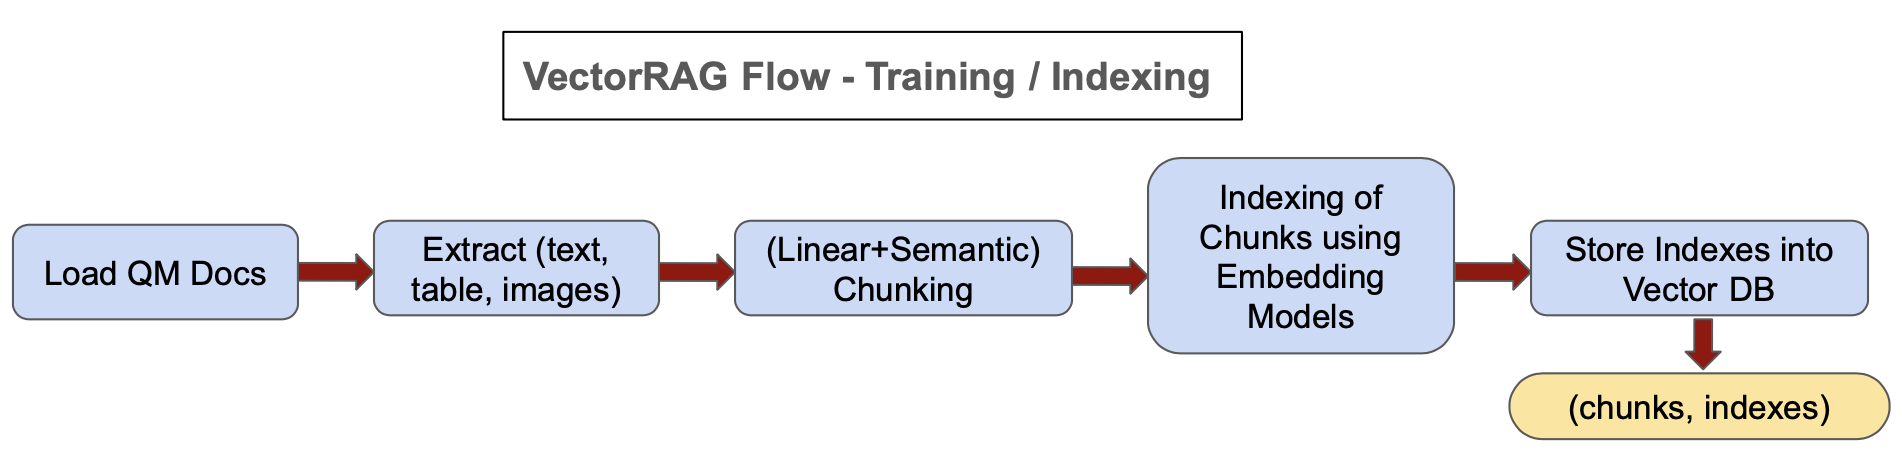

In [ ]:
if INFER_ONLY_MODE == False:
  # Perform indexing on Training Docs
  pdf_path_arr = qm_pdf_path_arr
  image_output_dir = os.path.join(RESULT_PATH, "images")
  pdf_extractor = PDFExtractor(pdf_path_arr)
  full_text = pdf_extractor.extract_text()
  # tables = pdf_extractor.extract_tables()
  # images = pdf_extractor.extract_images(output_dir=image_output_dir)

  linear_chunker = LinearChunker()
  linear_chunks = linear_chunker.get_chunks(full_text)
  print("Linear Chunks extracted from Training Docs!")
  semantic_chunker = SemanticChunker(model_name=EMB_MODEL_NAME)
  semantic_chunks = semantic_chunker.get_semantic_chunks(linear_chunks, normalize_embeddings = True)
  print("Semantic Chunks extracted from Linear Chunks of Training Docs!")
  semantic_embeddings = semantic_chunker.get_embeddings(semantic_chunks, normalize_embeddings = True)
  print("Semantic Embeddings extracted from Semantic Chunks of Training Docs!")

  vector_db = VectorDB(semantic_embeddings, semantic_chunks)
  print("Vector DB extracted from Semantic Chunks and Semantic Embeddings of Training Docs!")
  qm_rag_train_dict = {"chunks": semantic_chunks, "embeddings": semantic_embeddings, "vector_db": vector_db}
  if not os.path.isdir(VECTOR_DB_PATH):
      os.mkdir(VECTOR_DB_PATH)
  # print("Vector DB stored into VECTOR_DB_PATH")
  rag_train_path = os.path.join(VECTOR_DB_PATH, "rag_chunks_emb_db.pkl")
  with open(rag_train_path, "wb") as f:
      pickle.dump(qm_rag_train_dict, f)
  print("qm_rag_train_dict stored into rag_train_path")

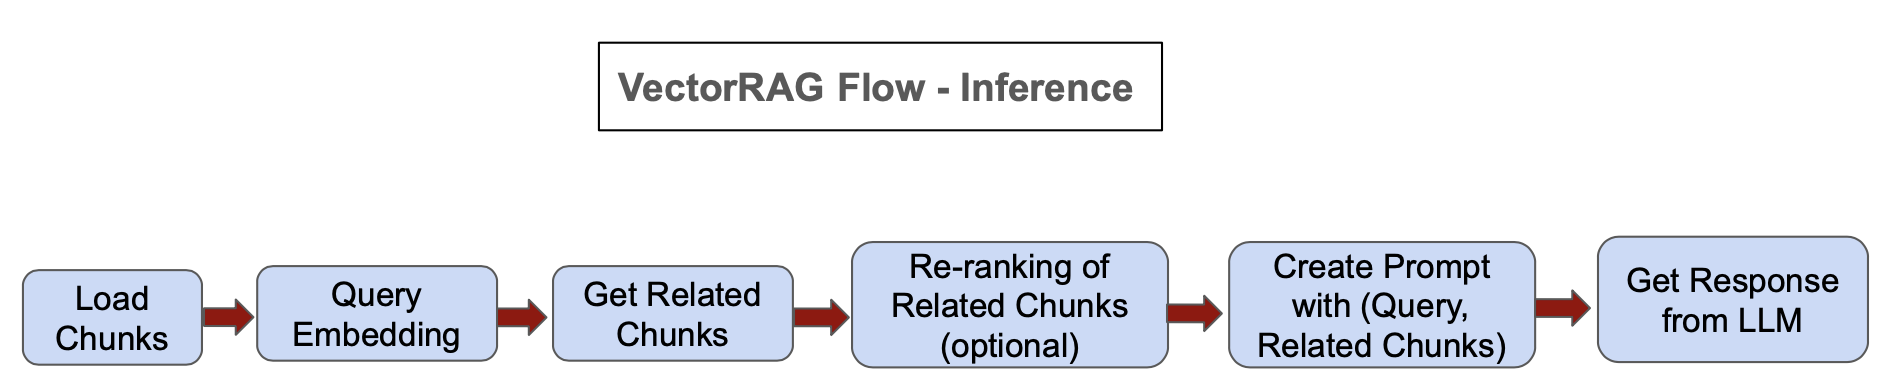

In [ ]:
# Inference Flow: Query & Response
# Step 1. Load the already saved chunks and embeddings
import os
import pickle

qm_rag_train_dict = {}
rag_train_path = os.path.join(VECTOR_DB_PATH, "rag_chunks_emb_db.pkl")
# print(rag_train_path)
with open(rag_train_path, "rb") as f:
    qm_rag_train_dict = pickle.load(f)
print(qm_rag_train_dict.keys())
semantic_chunks = qm_rag_train_dict["chunks"]
semantic_embeddings = qm_rag_train_dict["embeddings"]
vector_db = qm_rag_train_dict["vector_db"]

print(type(semantic_chunks))
print(type(semantic_embeddings))
print(type(vector_db))

# Step 2. Query Input from QueryDB
QueryDB_Path = os.path.join(DATA_PATH, "QM_Chapter_Queries.json")
with open(QueryDB_Path, mode="rb") as f:
    query_dict = json.load(f)


In [ ]:
# Instatiate LLM and RAG classes
llm = LLM_Model(llm_model_name=RESP_MODEL_NAME)
rag = RAGMain(vector_db, llm, reranker_model_name=RERANKER_MODEL_NAME)
rag_evaluator = RAGEval(llm, rag)

In [ ]:
def ask_vector_rag(llm, rag, rag_evaluator, query):
    # llm_output = llm.generate_response(query)
    rag_output = rag.generate_response(query)
    resp_eval_dict = rag_evaluator.evaluate_on_query(query)
    print(f"Query: {query}")
    # print(f"Simple LLM output (without RAG): {llm_output}")
    print(f"Vector RAG output: {rag_output}")
    print(f"RAG Evaluation: Can Be Answered = {resp_eval_dict['can_be_answered']}")
    print(f"RAG Evaluation: Is Answered = {resp_eval_dict['is_answered']}")

In [ ]:
query = "What is the Heisenberg uncertainty principle? Provide a simple example using position and momentum to illustrate this concept."
ask_vector_rag(llm, rag, rag_evaluator, query)

In [ ]:
query = "Describe the function of a quantum superposition and how it differs from a classical superposition of states."
ask_vector_rag(llm, rag, rag_evaluator, query)

In [ ]:
query = "What is the primary difference between a classical bit and a quantum bit (qubit)?"
ask_vector_rag(llm, rag, rag_evaluator, query)

In [ ]:
query = "Explain the concept of a quantum gate and how it is used to manipulate qubits. Provide an example of a common quantum gate and its purpose."
ask_vector_rag(llm, rag, rag_evaluator, query)

In [ ]:
query = "What actually is the Eye of Jupiter? Can you explain in simple terms?"
ask_vector_rag(llm, rag, rag_evaluator, query)